## Step 1: Let's define some model building blocks

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

### MLP

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, activation="sigmoid", use_batchnorm=False):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.LazyLinear(256)
        self.fc2 = nn.Linear(256, 10)

        self.use_batchnorm = use_batchnorm
        if use_batchnorm:
            self.bn1 = nn.BatchNorm1d(256)

        # Activation
        if activation == "sigmoid":
            self.activation = nn.Sigmoid()
        elif activation == "relu":
            self.activation = nn.ReLU()
        else:
            raise ValueError(f"Unsupported activation: {activation}")

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        if self.use_batchnorm:
            x = self.bn1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

In [ ]:
class PureConvCNN(nn.Module):
    def __init__(
        self, in_channels=1, num_classes=10, activation="sigmoid", use_batchnorm=False
    ):
        super().__init__()

        # --- Activation selection ---
        if activation == "sigmoid":
            self.act = nn.Sigmoid()
        elif activation == "relu":
            self.act = nn.ReLU()
        else:
            raise ValueError(f"Unsupported activation: {activation}")

        self.use_batchnorm = use_batchnorm

        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, stride=1, padding=1)
        if use_batchnorm:
            self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        if use_batchnorm:
            self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.classifier = nn.Conv2d(32, num_classes, kernel_size=7, stride=1, padding=0)
        self.global_avg = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.conv1(x)
        if self.use_batchnorm:
            x = self.bn1(x)
        x = self.act(x)
        x = self.pool1(x)

        x = self.conv2(x)
        if self.use_batchnorm:
            x = self.bn2(x)
        x = self.act(x)
        x = self.pool2(x)

        x = self.classifier(x)
        x = self.global_avg(x)
        x = torch.flatten(x, 1)
        return x

## Training & Plotting Architecture

This needs to do the following:
- create an api/function so that if i pass it a model and some data it will invoke the train function
- return the model to me so that i can then go on and test the function out 
- return data related to the loss and accuracy of the modle after each epoch of training



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time


def _make_optimizer(model, name="sgd", lr=0.05):
    name = name.lower()
    if name == "sgd":
        return optim.SGD(model.parameters(), lr=lr)
    if name == "adam":
        return optim.Adam(model.parameters(), lr=lr)
    raise ValueError(f"Unknown optimizer: {name}")


@torch.no_grad()
def evaluate(model, loader, device="cpu", criterion=None):
    model.eval()
    total, correct, total_loss = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        if criterion is not None:
            total_loss += criterion(logits, y).item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)
    avg_loss = (total_loss / total) if criterion is not None else None
    acc = correct / total
    return avg_loss, acc


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def train_model(
    model,
    train_loader,
    test_loader,
    epochs=15,
    optimizer_name="sgd",
    lr=0.05,
    device=None,
    log_every=100,
):
    """
    Train on `train_loader`, evaluate on `test_loader` each epoch.
    Returns (trained_model, history) where:
      history = {
        'train_loss': [...], 'train_acc': [...],
        'test_loss':  [...], 'test_acc':  [...]
      }
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Loss + optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = _make_optimizer(model, optimizer_name, lr)

    history = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    print(f"\n Starting training on device: {device.upper()}")
    start_time = time.time()

    for epoch in range(1, epochs + 1):
        model.train()
        total, correct, total_loss = 0, 0, 0.0

        for step, (x, y) in enumerate(train_loader, 1):
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x.size(0)
            correct += (logits.argmax(1) == y).sum().item()
            total += x.size(0)

            if log_every and (step % log_every == 0):
                print(f"epoch {epoch} step {step}: loss={loss.item():.4f}")

        # per-epoch metrics
        train_loss = total_loss / total
        train_acc = correct / total
        test_loss, test_acc = evaluate(
            model, test_loader, device=device, criterion=criterion
        )

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)

        print(
            f"[{epoch}/{epochs}] "
            f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
            f"test_loss={test_loss:.4f} test_acc={test_acc:.4f}"
        )

    end_time = time.time()
    elapsed = end_time - start_time
    params = count_parameters(model)

    final_train_loss = history["train_loss"][-1]
    final_train_acc = history["train_acc"][-1]
    final_test_loss = history["test_loss"][-1]
    final_test_acc = history["test_acc"][-1]

    print("\n=== Training Summary Overview ===")
    print(f"Model Type:       {model.__class__.__name__}")
    print(f"Parameters:       {params:,}")
    print(f"Optimizer:        {optimizer_name.upper()}")
    print(f"Learning Rate:    {lr}")
    print(f"Epochs Trained:   {epochs}")
    print(f"Training Time:    {elapsed:.2f} sec ({elapsed/60:.2f} min)")
    print(f"Final Train Loss: {final_train_loss:.4f}")
    print(f"Final Train Acc:  {final_train_acc*100:.2f}%")
    print(f"Final Test Loss:  {final_test_loss:.4f}")
    print(f"Final Test Acc:   {final_test_acc*100:.2f}%")
    print("=====================================\n")

    return model, history

In [5]:
def test_model(model, test_loader, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    _, acc = evaluate(model, test_loader, device=device, criterion=None)
    return acc

In [ ]:
def plot_history(history, title="Training History"):
    """
    Plots train/test loss and accuracy curves from a history dictionary:
    history = {
        'train_loss': [...],
        'train_acc':  [...],
        'test_loss':  [...],
        'test_acc':   [...]
    }
    """
    epochs = np.arange(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history["train_loss"], "o-", label="Train Loss")
    plt.plot(epochs, history["test_loss"], "s-", label="Test Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xticks(epochs)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history["train_acc"], "o-", label="Train Accuracy")
    plt.plot(epochs, history["test_acc"], "s-", label="Test Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.xticks(epochs)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.show()

In [ ]:
@torch.no_grad()
def plot_output_sigmoid_distribution(
    model, loader, device=None, max_batches=1, title="Output Sigmoid Distribution"
):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.eval().to(device)

    vals = []
    seen = 0
    for x, _ in loader:
        x = x.to(device)
        logits = model(x)  # model output BEFORE any sigmoid
        probs = torch.sigmoid(logits)  # second sigmoid (applied here manually)
        vals.append(probs.flatten().cpu())
        seen += 1
        if seen >= max_batches:
            break

    vals = torch.cat(vals).numpy()
    plt.figure(figsize=(6, 4))
    plt.hist(vals, bins=50, density=True, alpha=0.8)
    plt.xlabel("Sigmoid(logits)")
    plt.ylabel("Density")
    plt.title(title)
    plt.show()

## Preparing the Data (MNIST and CIFAR-10)

In [7]:
mnist_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

mnist_train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=mnist_transform
)
mnist_test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=mnist_transform
)

mnist_train_loader = torch.utils.data.DataLoader(
    mnist_train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True
)
mnist_test_loader = torch.utils.data.DataLoader(
    mnist_test_dataset, batch_size=1000, shuffle=False, num_workers=2, pin_memory=True
)

print(
    "MNIST data loaded:",
    f"\n  Training samples: {len(mnist_train_dataset)}",
    f"\n  Test samples: {len(mnist_test_dataset)}",
)

MNIST data loaded: 
  Training samples: 60000 
  Test samples: 10000


In [15]:
cifar10_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616)
        ),
    ]
)

cifar10_train_dataset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=cifar10_transform
)
cifar10_test_dataset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=cifar10_transform
)

cifar10_train_loader = torch.utils.data.DataLoader(
    cifar10_train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True
)
cifar10_test_loader = torch.utils.data.DataLoader(
    cifar10_test_dataset, batch_size=1000, shuffle=False, num_workers=2, pin_memory=True
)

print(
    "CIFAR-10 data loaded:",
    f"\n  Training samples: {len(cifar10_train_dataset)}",
    f"\n  Test samples: {len(cifar10_test_dataset)}",
)

Files already downloaded and verified
Files already downloaded and verified
CIFAR-10 data loaded: 
  Training samples: 50000 
  Test samples: 10000


## Testing Models with Data

### Scenerio 1: Base Parameters

In [9]:
# Base Params:
# Optimizer: SGD; Learning rate: 0.05; BatchSize: 64; Epochs: 15; Loss function: CrossEntropyLoss
config = {"learning_rate": 0.05, "epochs": 15, "optimizer": "sgd"}

In [18]:
base_mlp_mnist = SimpleMLP(activation="sigmoid")
base_mlp_cifar10 = SimpleMLP(activation="sigmoid")

base_cnn_mnist = PureConvCNN(in_channels=1, num_classes=10, activation="sigmoid")
base_cnn_cifar10 = PureConvCNN(in_channels=3, num_classes=10, activation="sigmoid")

epoch 1 step 100: loss=1.1926
epoch 1 step 200: loss=0.7431
epoch 1 step 300: loss=0.5609
epoch 1 step 400: loss=0.5811
epoch 1 step 500: loss=0.3971
epoch 1 step 600: loss=0.4223
epoch 1 step 700: loss=0.3866
epoch 1 step 800: loss=0.2310
epoch 1 step 900: loss=0.4176
[1/15] train_loss=0.6205 train_acc=0.8470 | test_loss=0.3373 test_acc=0.9043
epoch 2 step 100: loss=0.3107
epoch 2 step 200: loss=0.3172
epoch 2 step 300: loss=0.2980
epoch 2 step 400: loss=0.3115
epoch 2 step 500: loss=0.3510
epoch 2 step 600: loss=0.2704
epoch 2 step 700: loss=0.2005
epoch 2 step 800: loss=0.3968
epoch 2 step 900: loss=0.2115
[2/15] train_loss=0.3140 train_acc=0.9098 | test_loss=0.2769 test_acc=0.9210
epoch 3 step 100: loss=0.2215
epoch 3 step 200: loss=0.3702
epoch 3 step 300: loss=0.1570
epoch 3 step 400: loss=0.2015
epoch 3 step 500: loss=0.3066
epoch 3 step 600: loss=0.4341
epoch 3 step 700: loss=0.1457
epoch 3 step 800: loss=0.0681
epoch 3 step 900: loss=0.2511
[3/15] train_loss=0.2699 train_acc=0

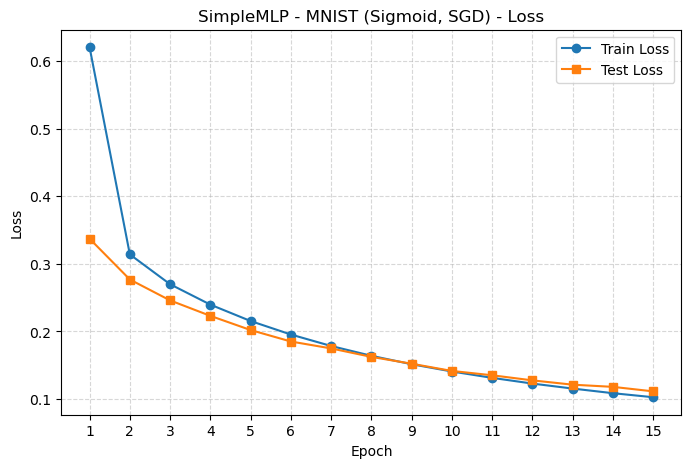

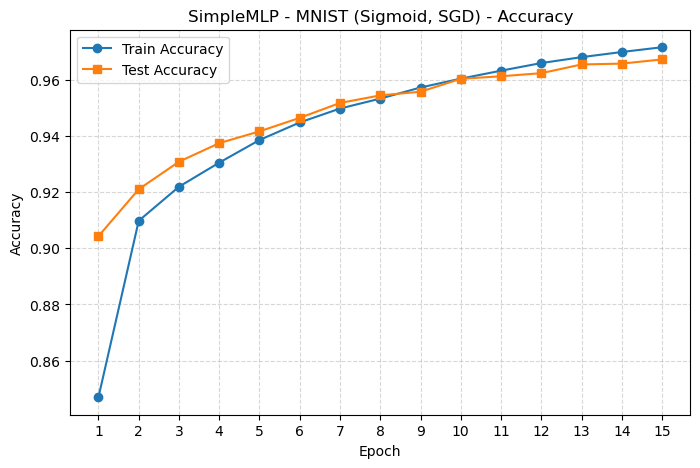

In [11]:
mlp_mnist_model, mlp_mnist_history = train_model(
    base_mlp_mnist,
    mnist_train_loader,
    mnist_test_loader,
    epochs=config["epochs"],
    optimizer_name=config["optimizer"],
    lr=config["learning_rate"],
)

plot_history(mlp_mnist_history, title="SimpleMLP - MNIST (Sigmoid, SGD)")

epoch 1 step 100: loss=2.3081
epoch 1 step 200: loss=2.1102
epoch 1 step 300: loss=1.4385
epoch 1 step 400: loss=0.8339
epoch 1 step 500: loss=0.6926
epoch 1 step 600: loss=0.4299
epoch 1 step 700: loss=0.4189
epoch 1 step 800: loss=0.4902
epoch 1 step 900: loss=0.4342
[1/15] train_loss=1.1276 train_acc=0.6388 | test_loss=0.4180 test_acc=0.8786
epoch 2 step 100: loss=0.3896
epoch 2 step 200: loss=0.2926
epoch 2 step 300: loss=0.3492
epoch 2 step 400: loss=0.4852
epoch 2 step 500: loss=0.3829
epoch 2 step 600: loss=0.3063
epoch 2 step 700: loss=0.4188
epoch 2 step 800: loss=0.4426
epoch 2 step 900: loss=0.4981
[2/15] train_loss=0.3538 train_acc=0.8973 | test_loss=0.2909 test_acc=0.9185
epoch 3 step 100: loss=0.3097
epoch 3 step 200: loss=0.1990
epoch 3 step 300: loss=0.1849
epoch 3 step 400: loss=0.1795
epoch 3 step 500: loss=0.3036
epoch 3 step 600: loss=0.3085
epoch 3 step 700: loss=0.4025
epoch 3 step 800: loss=0.2232
epoch 3 step 900: loss=0.2440
[3/15] train_loss=0.2661 train_acc=0

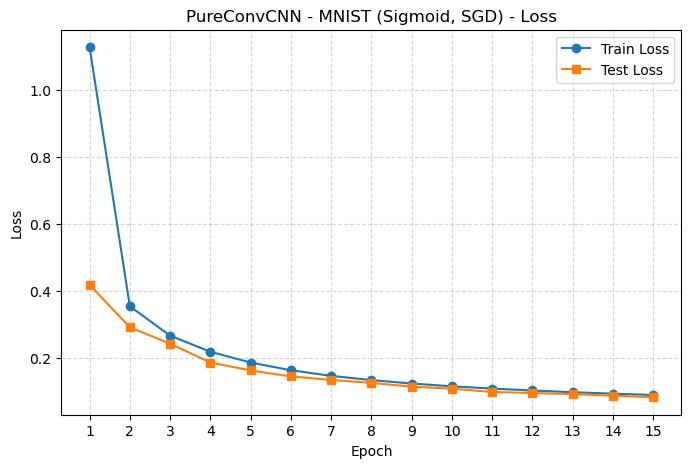

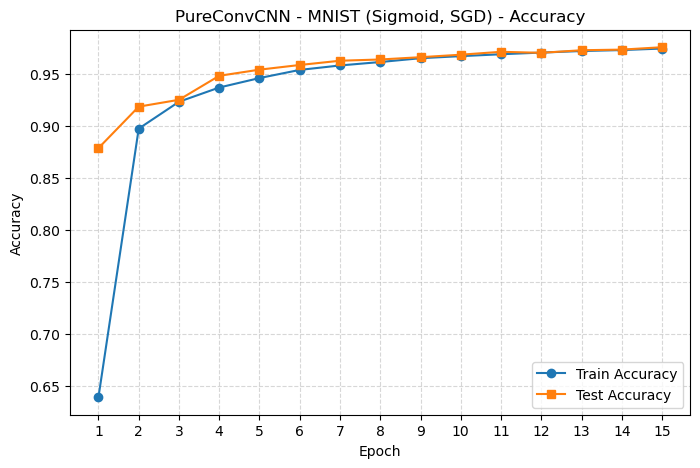

In [12]:
cnn_mnist_model, cnn_mnist_history = train_model(
    base_cnn_mnist,
    mnist_train_loader,
    mnist_test_loader,
    epochs=config["epochs"],
    optimizer_name=config["optimizer"],
    lr=config["learning_rate"],
)

plot_history(cnn_mnist_history, title="PureConvCNN - MNIST (Sigmoid, SGD)")

epoch 1 step 100: loss=1.7944
epoch 1 step 200: loss=1.7883
epoch 1 step 300: loss=1.7930
epoch 1 step 400: loss=1.7616
epoch 1 step 500: loss=1.7407
epoch 1 step 600: loss=1.7705
epoch 1 step 700: loss=2.0197
[1/15] train_loss=1.8352 train_acc=0.3560 | test_loss=1.7478 test_acc=0.3801
epoch 2 step 100: loss=1.6200
epoch 2 step 200: loss=1.8077
epoch 2 step 300: loss=1.8055
epoch 2 step 400: loss=1.6903
epoch 2 step 500: loss=1.7428
epoch 2 step 600: loss=1.7339
epoch 2 step 700: loss=1.4892
[2/15] train_loss=1.7064 train_acc=0.4063 | test_loss=1.7497 test_acc=0.3913
epoch 3 step 100: loss=1.7192
epoch 3 step 200: loss=1.8280
epoch 3 step 300: loss=1.5202
epoch 3 step 400: loss=1.8523
epoch 3 step 500: loss=1.8278
epoch 3 step 600: loss=1.7968
epoch 3 step 700: loss=1.6820
[3/15] train_loss=1.6547 train_acc=0.4259 | test_loss=1.6528 test_acc=0.4246
epoch 4 step 100: loss=1.6659
epoch 4 step 200: loss=1.7412
epoch 4 step 300: loss=1.6134
epoch 4 step 400: loss=1.7452
epoch 4 step 500: l

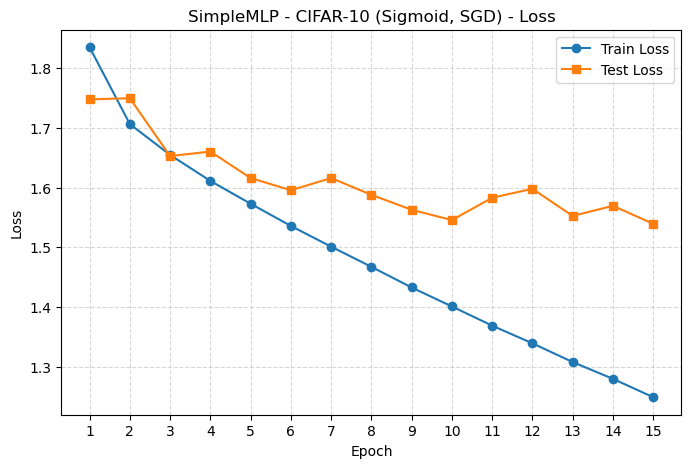

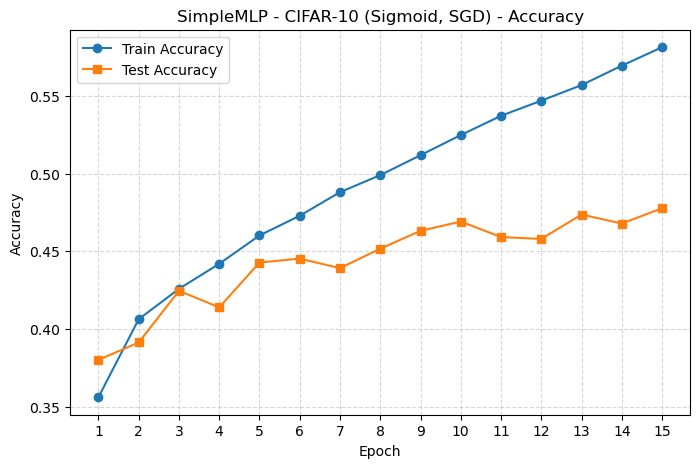

In [19]:
mlp_cifar10_model, mlp_cifar10_history = train_model(
    base_mlp_cifar10,
    cifar10_train_loader,
    cifar10_test_loader,
    epochs=config["epochs"],
    optimizer_name=config["optimizer"],
    lr=config["learning_rate"],
)

plot_history(mlp_cifar10_history, title="SimpleMLP - CIFAR-10 (Sigmoid, SGD)")

epoch 1 step 100: loss=2.4640
epoch 1 step 200: loss=2.2860
epoch 1 step 300: loss=2.2150
epoch 1 step 400: loss=2.0142
epoch 1 step 500: loss=1.9618
epoch 1 step 600: loss=2.0148
epoch 1 step 700: loss=1.9593
[1/15] train_loss=2.1410 train_acc=0.2119 | test_loss=2.0064 test_acc=0.2846
epoch 2 step 100: loss=1.8542
epoch 2 step 200: loss=1.9175
epoch 2 step 300: loss=2.2098
epoch 2 step 400: loss=1.8443
epoch 2 step 500: loss=1.9691
epoch 2 step 600: loss=1.8095
epoch 2 step 700: loss=1.6696
[2/15] train_loss=1.8658 train_acc=0.3380 | test_loss=1.8595 test_acc=0.3139
epoch 3 step 100: loss=1.5929
epoch 3 step 200: loss=1.6543
epoch 3 step 300: loss=1.8676
epoch 3 step 400: loss=1.7104
epoch 3 step 500: loss=1.7355
epoch 3 step 600: loss=1.7371
epoch 3 step 700: loss=1.7190
[3/15] train_loss=1.7313 train_acc=0.3890 | test_loss=1.7142 test_acc=0.3872
epoch 4 step 100: loss=1.6182
epoch 4 step 200: loss=1.5197
epoch 4 step 300: loss=1.6683
epoch 4 step 400: loss=1.5619
epoch 4 step 500: l

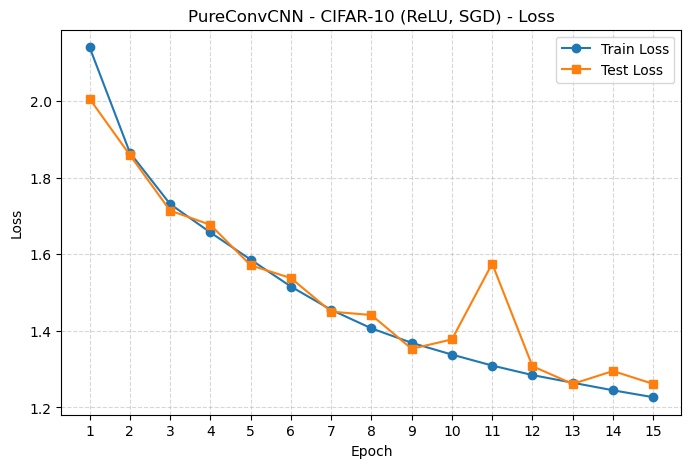

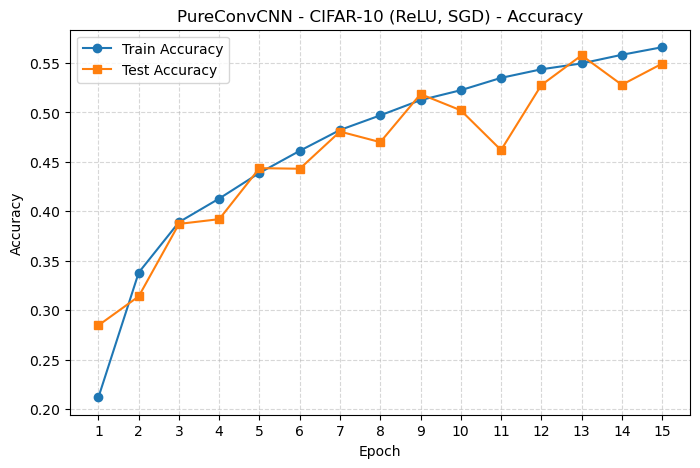

In [20]:
cnn_cifar10_model, cnn_cifar10_history = train_model(
    base_cnn_cifar10,
    cifar10_train_loader,
    cifar10_test_loader,
    epochs=config["epochs"],
    optimizer_name=config["optimizer"],
    lr=config["learning_rate"],
)

plot_history(cnn_cifar10_history, title="PureConvCNN - CIFAR-10 (ReLU, SGD)")

In [21]:
print("Final Test Accuracies:")
print(f"MLP (MNIST):    {test_model(mlp_mnist_model, mnist_test_loader):.4f}")
print(f"CNN (MNIST):    {test_model(cnn_mnist_model, mnist_test_loader):.4f}")
print(f"MLP (CIFAR-10): {test_model(mlp_cifar10_model, cifar10_test_loader):.4f}")
print(f"CNN (CIFAR-10): {test_model(cnn_cifar10_model, cifar10_test_loader):.4f}")

Final Test Accuracies:
MLP (MNIST):    0.9672
CNN (MNIST):    0.9757
MLP (CIFAR-10): 0.4778
CNN (CIFAR-10): 0.5493


## Scenerio 2: More Experiments

It is clear that for the MNIST dataset, the MLP does just as well as the CNN while being much more efficient to train on. moreover, the CNN model does signficiantly better for the CIFAR dataset. For the section "More Experiments", we will be comparing the results on two models: MLP on MNIST and CNN on CIFAR

### Experiment 1: Changing Activation from Sigmoid to ReLU

In [25]:
# new models with ReLU activation functions
relu_mlp_mnist = SimpleMLP(activation="relu")
relu_cnn_cifar10 = PureConvCNN(in_channels=3, num_classes=10, activation="relu")

# preserve base configs
base_config = {"learning_rate": 0.05, "epochs": 15, "optimizer": "sgd"}

epoch 1 step 100: loss=0.4181
epoch 1 step 200: loss=0.3792
epoch 1 step 300: loss=0.3306
epoch 1 step 400: loss=0.2522
epoch 1 step 500: loss=0.1832
epoch 1 step 600: loss=0.1160
epoch 1 step 700: loss=0.3087
epoch 1 step 800: loss=0.2414
epoch 1 step 900: loss=0.2694
[1/15] train_loss=0.3182 train_acc=0.9092 | test_loss=0.1939 test_acc=0.9437
epoch 2 step 100: loss=0.1390
epoch 2 step 200: loss=0.0993
epoch 2 step 300: loss=0.0595
epoch 2 step 400: loss=0.0604
epoch 2 step 500: loss=0.2243
epoch 2 step 600: loss=0.1185
epoch 2 step 700: loss=0.1302
epoch 2 step 800: loss=0.2435
epoch 2 step 900: loss=0.2418
[2/15] train_loss=0.1502 train_acc=0.9568 | test_loss=0.1267 test_acc=0.9619
epoch 3 step 100: loss=0.0983
epoch 3 step 200: loss=0.1581
epoch 3 step 300: loss=0.0472
epoch 3 step 400: loss=0.0715
epoch 3 step 500: loss=0.0221
epoch 3 step 600: loss=0.1422
epoch 3 step 700: loss=0.1389
epoch 3 step 800: loss=0.0650
epoch 3 step 900: loss=0.0716
[3/15] train_loss=0.1060 train_acc=0

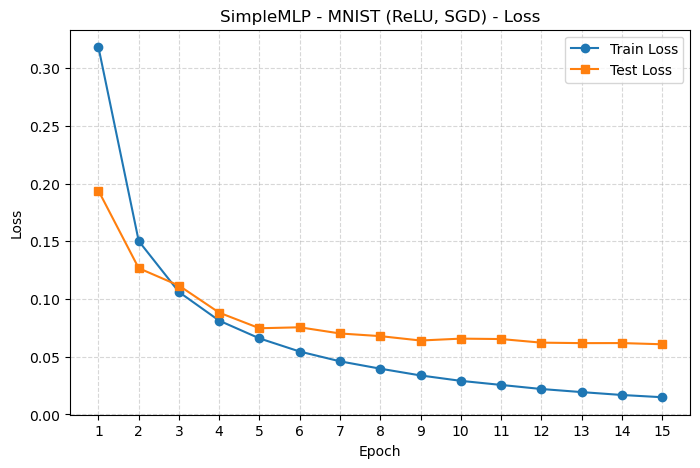

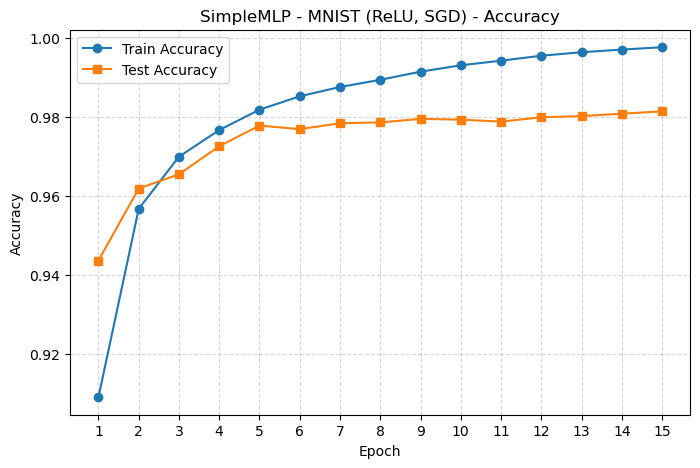

In [23]:
relu_mlp_mnist_model, relu_mlp_mnist_history = train_model(
    relu_mlp_mnist,
    mnist_train_loader,
    mnist_test_loader,
    epochs=base_config["epochs"],
    optimizer_name=base_config["optimizer"],
    lr=base_config["learning_rate"],
)

plot_history(relu_mlp_mnist_history, title="SimpleMLP - MNIST (ReLU, SGD)")

epoch 1 step 100: loss=1.7732
epoch 1 step 200: loss=1.7431
epoch 1 step 300: loss=1.5250
epoch 1 step 400: loss=1.2407
epoch 1 step 500: loss=1.4688
epoch 1 step 600: loss=1.3793
epoch 1 step 700: loss=1.6318
[1/15] train_loss=1.5805 train_acc=0.4315 | test_loss=1.4114 test_acc=0.4963
epoch 2 step 100: loss=1.1883
epoch 2 step 200: loss=1.3544
epoch 2 step 300: loss=1.4046
epoch 2 step 400: loss=1.1367
epoch 2 step 500: loss=1.1745
epoch 2 step 600: loss=1.0862
epoch 2 step 700: loss=1.3028
[2/15] train_loss=1.2295 train_acc=0.5639 | test_loss=1.4461 test_acc=0.4953
epoch 3 step 100: loss=0.8480
epoch 3 step 200: loss=1.0595
epoch 3 step 300: loss=0.9900
epoch 3 step 400: loss=1.1372
epoch 3 step 500: loss=0.9395
epoch 3 step 600: loss=1.1196
epoch 3 step 700: loss=0.9602
[3/15] train_loss=1.0892 train_acc=0.6186 | test_loss=1.1089 test_acc=0.6049
epoch 4 step 100: loss=1.0947
epoch 4 step 200: loss=0.7369
epoch 4 step 300: loss=0.9120
epoch 4 step 400: loss=1.0418
epoch 4 step 500: l

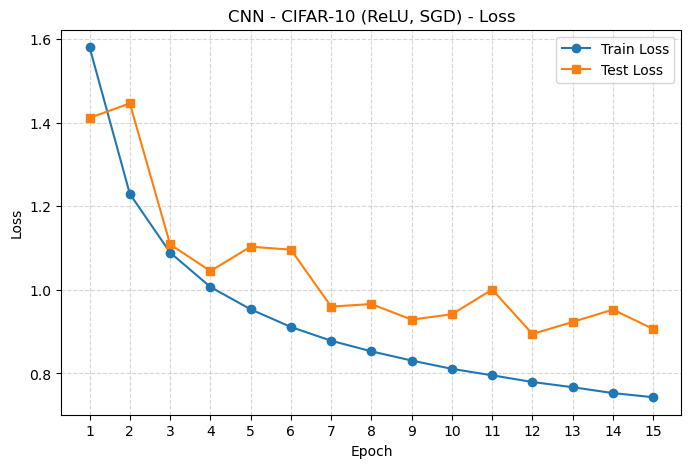

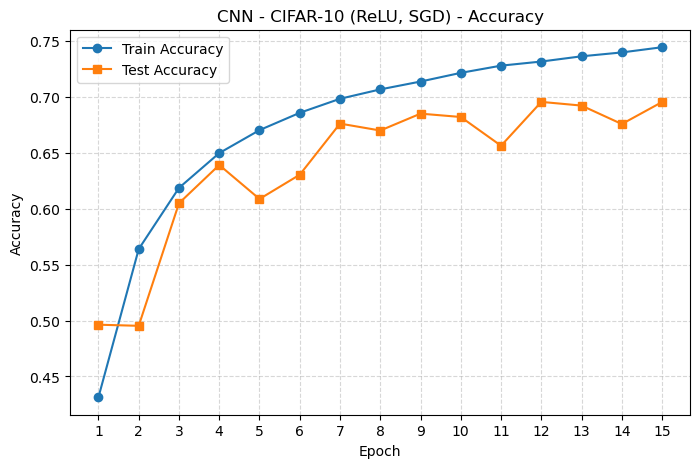

In [26]:
relu_cnn_cifar10_model, relu_cnn_cifar10_history = train_model(
    relu_cnn_cifar10,
    cifar10_train_loader,
    cifar10_test_loader,
    epochs=base_config["epochs"],
    optimizer_name=base_config["optimizer"],
    lr=base_config["learning_rate"],
)

plot_history(relu_cnn_cifar10_history, title="CNN - CIFAR-10 (ReLU, SGD)")

### Experiment 2: change optimizer from SGD to Adam

In [27]:
# get base models
base_mlp_mnist = SimpleMLP(activation="sigmoid")
base_cnn_cifar10 = PureConvCNN(in_channels=3, num_classes=10, activation="sigmoid")

# new configs
adam_config = {"learning_rate": 0.05, "epochs": 15, "optimizer": "adam"}

In [28]:
base_mlp_mnist_model, base_mlp_mnist_history = train_model(
    base_mlp_mnist,
    mnist_train_loader,
    mnist_test_loader,
    epochs=adam_config["epochs"],
    optimizer_name=adam_config["optimizer"],
    lr=adam_config["learning_rate"],
)

plot_history(base_mlp_mnist_history, title="SimpleMLP - MNIST (ReLU, SGD)")

epoch 1 step 100: loss=0.5255
epoch 1 step 200: loss=0.6288


KeyboardInterrupt: 

In [29]:
base_cnn_cifar10_model, base_cnn_cifar10_history = train_model(
    base_cnn_cifar10,
    cifar10_train_loader,
    cifar10_test_loader,
    epochs=config["epochs"],
    optimizer_name=config["optimizer"],
    lr=config["learning_rate"],
)

plot_history(base_cnn_cifar10_history, title="CNN - CIFAR-10 (base, SGD)")

epoch 1 step 100: loss=2.2875
epoch 1 step 200: loss=2.2861
epoch 1 step 300: loss=2.1502
epoch 1 step 400: loss=2.1773
epoch 1 step 500: loss=2.0858


KeyboardInterrupt: 

### Experiment 3: Adding and observing Batch Normalization

In [ ]:
batchnorm_mlp_mnist = SimpleMLP(activation="relu", use_batchnorm=True)
batchnorm_cnn_cifar10 = PureConvCNN(
    in_channels=3, num_classes=10, activation="relu", use_batchnorm=True
)

base_config = {"learning_rate": 0.05, "epochs": 15, "optimizer": "sgd"}

In [ ]:
batchnorm_mlp_mnist_model, batchnorm_mlp_mnist_history = train_model(
    batchnorm_mlp_mnist,
    mnist_train_loader,
    mnist_test_loader,
    epochs=base_config["epochs"],
    optimizer_name=base_config["optimizer"],
    lr=base_config["learning_rate"],
)

plot_history(batchnorm_mlp_mnist_history, title="SimpleMLP - MNIST (ReLU, SGD)")

In [ ]:
plot_output_sigmoid_distribution(
    batchnorm_mlp_mnist_model, mnist_test_loader, title="MLP+BN on MNIST"
)

In [ ]:
batchnorm_cnn_cifar10_model, batchnorm_cnn_cifar10_history = train_model(
    base_cnn_cifar10,
    cifar10_train_loader,
    cifar10_test_loader,
    epochs=base_config["epochs"],
    optimizer_name=base_config["optimizer"],
    lr=base_config["learning_rate"],
)

plot_history(batchnorm_cnn_cifar10_history, title="CNN - CIFAR-10 (base, SGD)")

In [ ]:
plot_output_sigmoid_distribution(
    batchnorm_cnn_cifar10_model, cifar10_test_loader, title="CNN+BN on CIFAR-10"
)

Experiment 4 will be analyzed in the paper. Appropriate metadata was collected throughout the training of all the models and will be reported in the paper.